In [6]:
!python -c "import platform; print(platform.architecture())"
!python -c "import sys; print(sys.executable)"

('64bit', 'WindowsPE')
c:\Users\sport\miniconda3\python.exe


# 0. Import Packages

In [7]:
from tqdm import tqdm

In [8]:
import pandas as pd
import numpy as np
import os
import gc

In [9]:
import joblib
from lightgbm import LGBMRegressor

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read Data

In [11]:
data = pd.read_pickle('02 Internediate Data/data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [12]:
valid.shape, test.shape

((853720, 3), (853720, 3))

In [13]:
INPUT_DIR = '../01 M5 Accuracy/01 Data'
calender = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
sales = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

# 2. Model Working

In [14]:
sales['store_id'] = sales['store_id'].astype('category')
data['store_id'] = data['store_id'].astype('category')


In [15]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()

In [16]:
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))

In [17]:
data.isna().sum()

id                                 0
item_id                            0
dept_id                            0
cat_id                             0
store_id                           0
state_id                           0
d                                  0
sold                               0
wm_yr_wk                           0
weekday                            0
wday                               0
month                              0
year                               0
event_name_1                       0
event_type_1                       0
event_name_2                       0
event_type_2                       0
snap_CA                            0
snap_TX                            0
snap_WI                            0
sell_price                  11661069
sold_lag_1                         0
sold_lag_2                         0
sold_lag_3                         0
sold_lag_6                         0
sold_lag_12                        0
sold_lag_24                        0
s

In [18]:
data = data.fillna(0)

In [19]:
data.isna().sum().sum()

np.int64(0)

In [20]:
model_dir = "03 Store Models/"

In [21]:

for store in tqdm(stores):
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    print(X_train.shape)
    print(X_valid.shape)

    #Train and validate
    model = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=6,
        num_leaves=5,
        min_child_weight=15
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse')
    
    
    
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = model_dir + 'model'+str(d_store_id[store])+'.pkl'

    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 0*****


c:\Users\sport\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sport\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\sport\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sport\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\sport\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3787
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 41
[LightGBM] [Info] Start training from score 1.324972


C:\Users\sport\AppData\Local\Temp\ipykernel_16548\1923674361.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00818941 0.00818941 0.00818941 ... 0.92129258 1.00117114 4.93884095]' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.
  valid_preds[X_valid.index] = model.predict(X_valid)
C:\Users\sport\AppData\Local\Temp\ipykernel_16548\1923674361.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00818941 0.00818941 0.00818941 ... 0.03031463 0.00818941 0.00818941]' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.
  eval_preds[X_test.index] = model.predict(X_test)
 10%|█         | 1/10 [00:15<02:21, 15.76s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 1*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 41
[LightGBM] [Info] Start training from score 0.978204


 20%|██        | 2/10 [00:30<02:02, 15.36s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 2*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4008
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 41
[LightGBM] [Info] Start training from score 1.927989


 30%|███       | 3/10 [00:45<01:45, 15.07s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 3*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3422
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 41
[LightGBM] [Info] Start training from score 0.707667


 40%|████      | 4/10 [01:00<01:29, 14.95s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 4*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3740
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 0.963681


 50%|█████     | 5/10 [01:14<01:14, 14.83s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 5*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3899
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 1.241402


 60%|██████    | 6/10 [01:29<00:58, 14.72s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 6*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 1.049304


 70%|███████   | 7/10 [01:44<00:44, 14.76s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 7*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3555
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 0.889008


 80%|████████  | 8/10 [01:59<00:29, 14.86s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 8*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3783
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 1.131519


 90%|█████████ | 9/10 [02:13<00:14, 14.72s/it]

(5726022, 42)
(85372, 42)
*****Prediction for Store: 9*****
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.288740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3826
[LightGBM] [Info] Number of data points in the train set: 5726022, number of used features: 42
[LightGBM] [Info] Start training from score 1.101072


100%|██████████| 10/10 [02:27<00:00, 14.79s/it]


# 3. Feature Importances

In [22]:
os.listdir("03 Store Models/")

['model0.pkl',
 'model1.pkl',
 'model2.pkl',
 'model3.pkl',
 'model4.pkl',
 'model5.pkl',
 'model6.pkl',
 'model7.pkl',
 'model8.pkl',
 'model9.pkl']

100%|██████████| 10/10 [00:00<00:00, 157.83it/s]


03 Store Models/model0.pkl
03 Store Models/model1.pkl
03 Store Models/model2.pkl
03 Store Models/model3.pkl
03 Store Models/model4.pkl
03 Store Models/model5.pkl
03 Store Models/model6.pkl
03 Store Models/model7.pkl
03 Store Models/model8.pkl
03 Store Models/model9.pkl


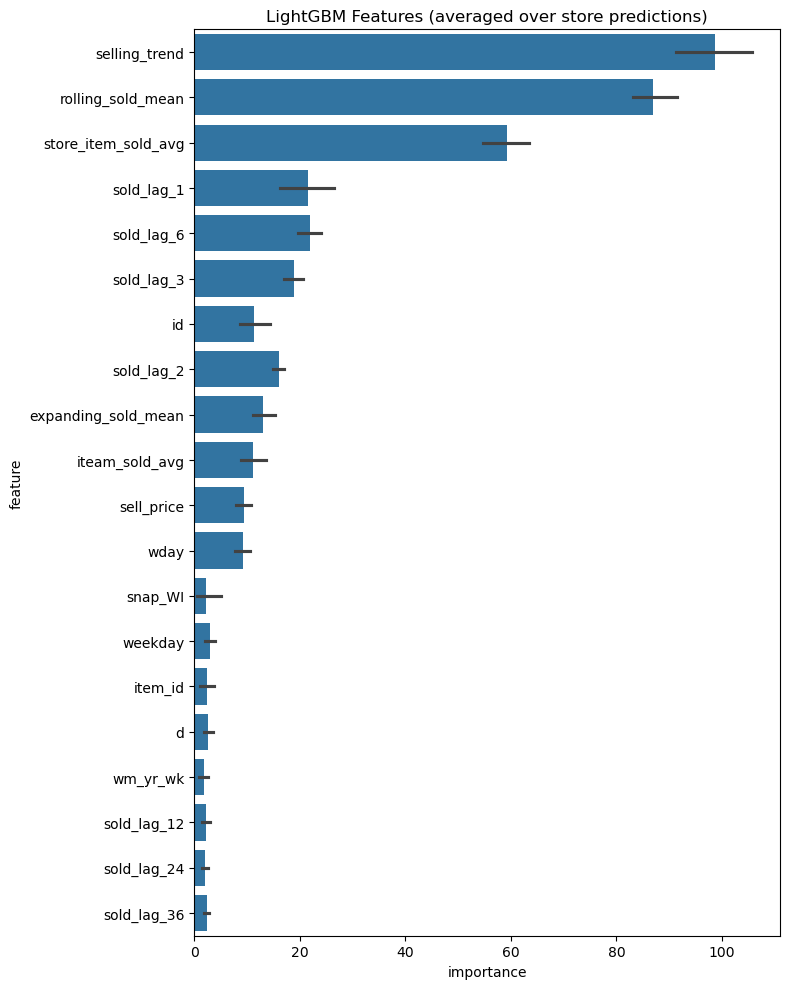

In [27]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in tqdm(os.listdir(model_dir)):
    if 'model' in filename:
        # load model
        full_path = model_dir + filename
        print(full_path)
        model = joblib.load(full_path)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# 4. Submission File

In [30]:
data['id'] = data['id'].astype('category')
d_id = dict(zip(data.id.cat.codes, data.id))

In [33]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=pd.read_csv('/01 Data/sales_train_validation.csv').id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    # validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('04 Output/submission.csv',index=False)